# `012` Recurrent Neural Networks

Requirements: 007 Initialization, 008 Batch normalization

All the models described until now are what it's called feedforward neural networks. This means that the information always flows in one direction, from the input to the output. However, there are some problems that require a different approach. For example, when the input is a variable-length sequence, like text or time series, we need a model that can handle this kind of data. **Recurrent Neural Networks** (RNNs) are a type of neural network that was invented in the 1970s inspired in the Ising model of statistical mechanics. The idea is to have:
* Have a hidden state that is updated at each time step
* Use the hidden state to make predictions

Let's implement a very minimal RNN to see how this can work in practice. We will be using a dataset of names from different countries, and we will train the RNN to predict from which country a name is.

In [1]:
from json import loads
from matplotlib import pyplot as plt
from random import shuffle
import torch

In [2]:
with open('custom-data/names.json', encoding='utf-8') as f:
	data = loads(f.read().lower())

nationalities = list(data.keys())
characters = sorted({c for names in data.values() for name in names for c in name})
c2i = {c: i for i, c in enumerate(characters)}
i2c = {i: c for i, c in enumerate(characters)}

X, Y = [], []
for nationality, names in data.items():
	for name in names:
		X.append(torch.tensor([c2i[c] for c in name]))
		Y.append(nationalities.index(nationality))

indices = list(range(len(X)))
shuffle(indices)
X = [X[i] for i in indices]
Y = torch.tensor([Y[i] for i in indices])

print(f'Loaded {len(X)} names from {len(nationalities)} nationalities using {len(characters)} different characters')
print(X[0], Y[0], '->', ''.join(i2c[i.item()] for i in X[0]), nationalities[Y[0]])

Loaded 20074 names from 18 nationalities using 58 different characters
tensor([24,  7, 17, 14, 21, 28]) tensor(14) -> rakhov russian


Now let's define the RNN. There are so many ways to arbitrarily define a RNN, but we will use the following:
* Initially, the hidden state is a vector of zeros.
* At each time step, we will first transform the hidden state using a linear transformation.
* Then, we will also apply a linear transformation to the input.
* After that, the new hidden state is the sum of the transformed hidden state and the transformed input, passed through a non-linear activation function.
* Finally, we make our prediction using a linear transformation of the final hidden state, and then applying $log(sofmax(x))$ to get the probabilities.

The choose of activation function is just to show that we can use any activation function we want, not just ReLU all the time like we have been doing. The architecture could be changed in different ways such as concatenating the input and the hidden state before applying a linear transformation, using multiple hidden states, etc.

In [3]:
class RNN(torch.nn.Module):
	def __init__(self, input_size, hidden_size, output_size):
		super(RNN, self).__init__()
		self.hidden_size = hidden_size
		self.one_hot = torch.eye(input_size)
		self.i2h = torch.nn.Linear(input_size, hidden_size)
		self.h2h = torch.nn.Linear(hidden_size, hidden_size)
		self.h2o = torch.nn.Linear(hidden_size, output_size)

	def forward(self, input):
		hidden = torch.zeros(1, self.hidden_size)
		for i in input:
			h = self.h2h(hidden)
			i = self.i2h(self.one_hot[i])
			hidden = (h + i).tanh()
		return self.h2o(hidden)

model = RNN(len(characters), 512, len(nationalities))
print(f'Created model with {sum(p.numel() for p in model.parameters())} parameters')

Created model with 302098 parameters


Now let's train our model. Since every name has a different length, we can't leverage pytorch's capabilities of processing in parallel many examples in a minibatch.

In [4]:
def train(model, iterations=100000, lr=0.003):
	optimizer = torch.optim.SGD(model.parameters(), lr=lr)
	criterion = torch.nn.CrossEntropyLoss()
	losses = []
	for epoch in range(iterations):
		ix = torch.randint(len(X), (1,)).item()
		x, y = X[ix], Y[ix]
		output = model(x)
		loss = criterion(output.view(1, -1), y.view(1))
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		losses.append(loss.item())
		if epoch % 10000 == 0:
			print(f'Epoch {epoch} loss: {loss.item()}')
	return losses

losses = train(model)
losses.extend(train(model, lr=0.0003))

Epoch 0 loss: 2.998095750808716
Epoch 10000 loss: 0.899265468120575
Epoch 20000 loss: 2.4729769229888916
Epoch 30000 loss: 0.0164965707808733
Epoch 40000 loss: 1.7645132541656494
Epoch 50000 loss: 0.03481963276863098
Epoch 60000 loss: 0.02007044292986393
Epoch 70000 loss: 0.21834883093833923
Epoch 80000 loss: 0.2851865887641907
Epoch 90000 loss: 0.07796403020620346
Epoch 0 loss: 1.5231068134307861
Epoch 10000 loss: 0.0658421739935875
Epoch 20000 loss: 0.058765023946762085
Epoch 30000 loss: 0.332966685295105
Epoch 40000 loss: 0.0024840945843607187
Epoch 50000 loss: 0.2291429191827774
Epoch 60000 loss: 0.12303487956523895
Epoch 70000 loss: 0.9497635960578918
Epoch 80000 loss: 0.001212338567711413
Epoch 90000 loss: 3.070244550704956


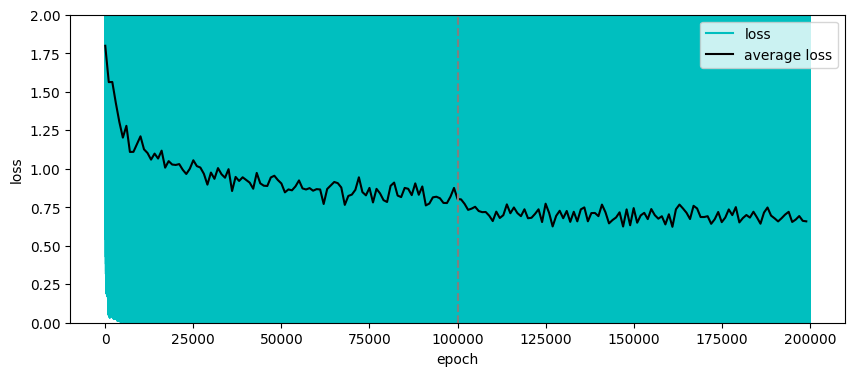

In [5]:
average_losses = torch.tensor(losses).view(-1, 1000).mean(1)
plt.figure(figsize=(10, 4))
plt.plot(losses, c='c', label='loss')
plt.plot(range(0, len(losses), 1000), average_losses, c='k', label='average loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.ylim(0, 2)
plt.axvline(100000, c='gray', linestyle='--');

You can see how the training is much longer than with the previous models, and judging by the loss it seems that the model could even use more training. Since we are not using any kind of layer normalization, this model is very sensitive to vanishing or exploding gradients. This problem becomes worse as the sequence length increases, and the model can't learn long-range dependencies.

Finally, let's test a bit what we have.

In [7]:
for name in 'alicia', 'dominik', 'muhammad', 'shinya':
	print(name)
	name_ix = [c2i[c] for c in name]
	probs = model(name_ix)[0]
	top = torch.topk(probs, 3)
	for i in range(3):
		print(f'\t{nationalities[top.indices[i]]}: {top.values[i].item():.2f}')

alicia
	italian: 5.02
	arabic: 4.59
	spanish: 4.44
dominik
	russian: 5.40
	czech: 3.79
	english: 2.53
muhammad
	arabic: 6.03
	english: 2.97
	russian: 2.94
shinya
	japanese: 5.32
	russian: 3.99
	czech: 3.14
